<a href="https://colab.research.google.com/github/MuhammadBilall/FIX-Parser/blob/main/FIX_Parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
from google.colab import drive
drive.mount('/content/drive')   

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
dataFolder = '/content/drive/MyDrive/FIX-Messages(1 month)/' 

In [80]:
import pandas as pd
import os
import glob
dataFiles = []
txt_files = glob.glob(dataFolder + "*.txt")
#print(txt_files)
for filename in txt_files:  
    print("Reading File: ", filename)
    data = pd.read_fwf(filename, header=None)
    dataFiles.append(data)

#print(dataFiles[0])

Reading File:  /content/drive/MyDrive/FIX-Messages(1 month)/2020-11-02 Messages.txt
Reading File:  /content/drive/MyDrive/FIX-Messages(1 month)/2020-11-06 Messages.txt
Reading File:  /content/drive/MyDrive/FIX-Messages(1 month)/2020-11-04 Messages.txt
Reading File:  /content/drive/MyDrive/FIX-Messages(1 month)/2020-11-10 Messages.txt
Reading File:  /content/drive/MyDrive/FIX-Messages(1 month)/2020-11-05 Messages.txt
Reading File:  /content/drive/MyDrive/FIX-Messages(1 month)/2020-11-09 Messages.txt
Reading File:  /content/drive/MyDrive/FIX-Messages(1 month)/2020-11-03 Messages.txt
Reading File:  /content/drive/MyDrive/FIX-Messages(1 month)/2020-11-19 Messages.txt
Reading File:  /content/drive/MyDrive/FIX-Messages(1 month)/2020-12-01 Messages.txt
Reading File:  /content/drive/MyDrive/FIX-Messages(1 month)/2020-11-18 Messages.txt
Reading File:  /content/drive/MyDrive/FIX-Messages(1 month)/2020-11-24 Messages.txt
Reading File:  /content/drive/MyDrive/FIX-Messages(1 month)/2020-11-27 Messa

In [81]:
def GetTagValue(msg, tag):  
    splits = msg.split("\001")
    for s in splits:
        temp = s.split("=")
        #print(len(temp))
        if temp[0] == tag:
            if (len(temp)>1):    #For handling missing values in tags
                return temp[1]
    return -1       
        

In [82]:
def ToDataFrame(dataFiles, tags):
    dataChunks = []

    for data in dataFiles:
        rows = []

        for i in range(len(data)):
            row = []

            for tag in tags:
                msg = data.at[i,0]
                
                value = GetTagValue(msg, tag)
                #print("msg num: ", i, "tag: ", tag, "value: ", value)
                row.append(value)

            rows.append(row)

        dataChunks.append(pd.DataFrame(rows, columns = tags))
        
    dataFrame = pd.concat(dataChunks, ignore_index=True)
    return dataFrame

In [83]:
tags = ['52','55', '1', '109', '35', '39', '100']
dataFrame = ToDataFrame(dataFiles, tags)
print(dataFrame)

                           52    55  1       109 35  39        100
0       20201102-13:33:09.955   SSO -1    ETFARB  D  -1  WEX-BESTX
1       20201102-13:33:10.049   SSO -1    ETFARB  8   0  WEX-BESTX
2       20201102-13:33:11.591   SSO -1    ETFARB  8   2  WEX-BESTX
3       20201102-13:33:19.812   QLD -1    ETFARB  D  -1  WEX-BESTX
4       20201102-13:33:19.988   QLD -1    ETFARB  8   0  WEX-BESTX
...                       ...   ... ..       ... ..  ..        ...
373458  20201117-21:14:34.857  SPXW -1  OPSPRTRD  D  -1  WEX-SWEEP
373459  20201117-21:14:34.867  SPXW -1  OPSPRTRD  8   0  WEX-SWEEP
373460  20201117-21:14:34.868  SPXW -1  OPSPRTRD  8   2  WEX-SWEEP
373461  20201117-21:15:01.299  SPXW -1  OPSPRTRD  D  -1  WEX-SWEEP
373462  20201117-21:15:01.325  SPXW -1  OPSPRTRD  8   8  WEX-SWEEP

[373463 rows x 7 columns]


In [84]:
dataFrame.to_csv(os.path.join(dataFolder, 'CleanData.csv'), index=False)

In [85]:
!pip install maya

In [86]:
from datetime import datetime
import maya
times = dataFrame['52']
dt = []
hours = []
time = []
weekdays = []
day = []

for i in range(0,len(times)):
    dt.append(maya.parse(times[i]).datetime())
    hours.append(dt[i].hour)
    weekdays.append(dt[i].strftime('%A'))
    time.append(dt[i].time())
    day.append(dt[i].day)


In [87]:
from collections import Counter
#time_count = Counter(time)
hours_count = Counter(hours)
weekday_count = Counter(weekdays)
days_count = Counter(day)
#print(weekday_count)
#print(hours_count)
#print(days_count)

In [88]:
#How many accounts have traded a particular security
#Most active traded accounts.
#Least active traded accounts.

#Finding the trades
#Tag 35=8 OR Tag 39=1 OR Tag 39=2
options = ['1', '2'] 
Trades_df = dataFrame[(dataFrame['35'] == '8') | (dataFrame['39'].isin(options))]
#print(Trades_df)

#Droping messages with missing account ID
#Trades_df = Trades_df.drop(Trades_df[Trades_df['109'] == -1].index)
#Trades_df = Trades_df.drop(Trades_df[Trades_df['109'] == ''].index)

#Renaming Missing account numbers to DEFAULT
Trades_df['109'] = Trades_df['109'].replace(['',-1],'DEFAULT')

#Taking out ONLY Account ID and Security out of dataframe
accounts_symbols = Trades_df.filter(['109','55'], axis=1)
#Finding the number of unique accounts
accounts = accounts_symbols['109'].unique()

#Grouping by Account ID and summing each security with it
accounts_symbols_count = []
for account in accounts:
    accounts_symbols_count.append(accounts_symbols[accounts_symbols['109'] == account].groupby(['55']).count())

#Finding Most traded Account, Min traded Account
most_trades = 0
most_trade_acc = 0
min_trade = accounts_symbols_count[0]['109'].sum()
min_trade_acc = 0
for i in range (0,len(accounts)):
    total = accounts_symbols_count[i]['109'].sum()
    if  (total > most_trades):
        most_trades = total
        most_trade_acc = accounts[i]

    if  (total < min_trade):
        min_trade = total
        min_trade_acc = accounts[i]

print("Account with most trades: ", most_trade_acc)
print("Number of trades: ", most_trades)
print("\nAccount with least trades: ", min_trade_acc)
print("Number of trades: ", min_trade)

#Displaying The results
for i in range(0,len(accounts)):
    accounts_symbols_count[i] = accounts_symbols_count[i].sort_values(by='109', ascending=False)
    total = accounts_symbols_count[i]['109'].sum()
    accounts_symbols_count[i] = accounts_symbols_count[i].transpose()
    accounts_symbols_count[i].reset_index(drop=True, inplace=True)
    print("\nAccount ID:", accounts[i], "Total Trades: ", total) 
    display(accounts_symbols_count[i])
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


Account with most trades:  ETFARB
Number of trades:  156483

Account with least trades:  OPSP
Number of trades:  1

Account ID: ETFARB Total Trades:  156483


55,SSO,QLD,DBO,VXX,SOXX,FXI,YINN,CHAD,SVXY,TBF,UPRO,UVXY,TQQQ,GLD,UCO,SOXL,ASHR,USO,UGL,VIXY,SJNK,SHYG,TLT,TMV,TBT
0,80889,25688,14823,14729,4520,3605,3091,2417,1650,1452,816,502,427,426,375,307,183,170,144,115,85,28,24,13,4



Account ID: CEC Total Trades:  200


55,ZVZZT,UVV,BSX,SLG,COP,WRI,HR,BA,KR,ALL,WHR,GD,JBLU,MUR,SRE,CVS,T,CB,UDR,WMB,USM,WFC,MET,XOM,MMC,MMP,MO,LPX,TAP,NI,OKE,PRU,RAD,TRV,MCK,ADM,LLY,L,AIG,AMGN,AMKR,AVB,AVT,BAC,BMY,C,CAH,CI,CSCO,CVX,DHR,DIS,EMN,GS,HAS,HIG,JPM,AEP,KIM,JWN
0,16,12,8,7,6,6,6,6,5,5,5,5,4,4,4,4,4,4,4,4,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2



Account ID: REVCON Total Trades:  22796


55,NKLA,FSR,ACB,WKHS,BLNK,SBE,XPEV,QS,RIDE,CLVS,INO,TLRY,SDC,MPLN,LMND,JWN,GME,HYLN,PLTR,SPCE,NNOX,HTZGQ,KNDI,PIC,SRNE,FUBO,GTT,TTCF,GRWG,RKT,RVLV,IBIO,AMC,VXRT,KODK,SPWR,MAC
0,2387,2269,1946,1865,1576,1485,1405,1391,1225,1177,964,837,814,778,667,527,362,226,212,173,153,128,60,32,28,20,15,13,12,12,9,9,8,4,3,2,2



Account ID: OPSPRTRD Total Trades:  19193


55,TSLA,AMZN,AAPL,BABA,MRNA,SPXW,BA,PTON,NFLX,MSFT,OSTK,FSR,ROKU,NIO,RIOT,AMD,NKLA,RIDE,LI,PANW,FSLY,DBX,LULU,WORK,QCOM,WMT,SNOW,FB,ACB,BIGC,PYPL,ZM,SPCE,DIS,DKNG,BIIB,TSM,AMAT,RH,GRWG,ARLO,MU,KNDI,DDOG,GOOGL,CRM,RNG,FSLR,SHOP,SNAP,DOCU,SPX,QQQ,CLDR,KODK,SBUX,SNDL,SPG,TGT,UBER,TWTR,NLS,KXIN,RKT,YY,FTCH,BKNG,IWM,NDXP,BLNK,F,GE,SPY,SLV,RCL,SOLO
0,3599,1971,1797,755,738,737,673,614,440,384,347,343,333,324,287,280,272,266,249,235,228,212,204,200,194,188,186,182,179,160,152,148,145,142,138,136,134,117,112,102,99,90,83,83,80,78,75,74,72,56,53,48,39,31,28,27,25,25,24,24,24,20,17,13,12,12,12,12,9,9,8,7,6,6,6,3



Account ID: STOCKLOANPROP Total Trades:  244


55,HYLN
0,244



Account ID: DEFAULT Total Trades:  7889


55,XPEV,GME,TSLA,FSR,ZM,INO,NKLA,PTON,CLVS,ACB,ROKU,BA,WKHS,TLRY,PYPL,QS,SHOP,RIDE,PANW,NIO,AMD,DIS,LULU,BLNK,HYLN,SQ,TWLO,NFLX,KNDI,SBE,DDOG,SNAP,LMND,SPCE,DOCU,MU,NNOX,TGT,LI,QCOM,PLTR,BABA,MAC,MRNA,WORK,NVDA,SPXW,AMZN,SPWR,SDC,JWN,GRWG
0,816,753,512,490,446,393,326,320,306,296,260,229,221,210,206,184,180,150,136,128,121,105,95,94,94,76,69,64,58,54,46,42,42,42,38,38,36,32,29,26,24,16,16,12,10,9,9,9,8,5,4,4



Account ID: REVCO Total Trades:  24


55,RIDE,NNOX,CLVS,HYLN,ACB,FSR,SPCE,TLRY,WKHS,XPEV
0,5,4,3,3,2,2,2,1,1,1



Account ID: REV Total Trades:  21


55,CLVS,XPEV,SPCE,SPWR,ACB,PLTR
0,8,6,3,2,1,1



Account ID: REVC Total Trades:  31


55,FSR,XPEV,CLVS,ACB,GME,TLRY,NKLA,SPCE
0,11,7,5,2,2,2,1,1



Account ID: RE Total Trades:  15


55,RIDE,CLVS,TLRY,ACB,XPEV
0,5,3,3,2,2



Account ID: R Total Trades:  8


55,XPEV,HTZGQ,ACB,CLVS
0,4,2,1,1



Account ID: EMS-JSC Total Trades:  14


55,SPY
0,14



Account ID: OPSP Total Trades:  1


55,SPXW
0,1


Counter({16: 68378, 15: 67157, 18: 58330, 17: 54894, 20: 48659, 19: 45350, 14: 28625, 21: 1578, 13: 492})


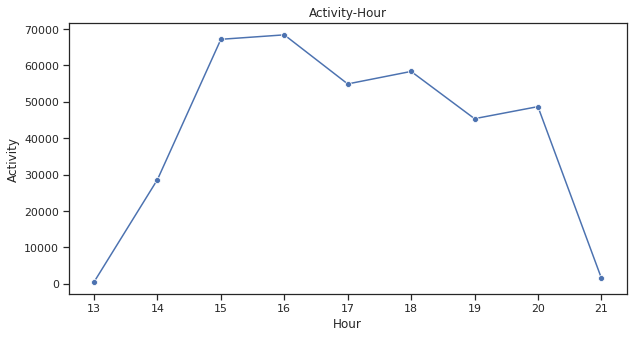

In [89]:
#Trade activity at a given time.
print(hours_count)
#print(dt[0])
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(10,5)})
sns.set_style("ticks")

plt.xlabel('Hour')
plt.ylabel('Activity')
plt.title('Activity-Hour')
sns.lineplot(data=hours_count, marker='o')
plt.show()

     WeekDay  Activity  DayNumber
0     Monday     83234          0
3    Tuesday     97687          1
2  Wednesday     67062          2
4   Thursday     60556          3
1     Friday     64924          4


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


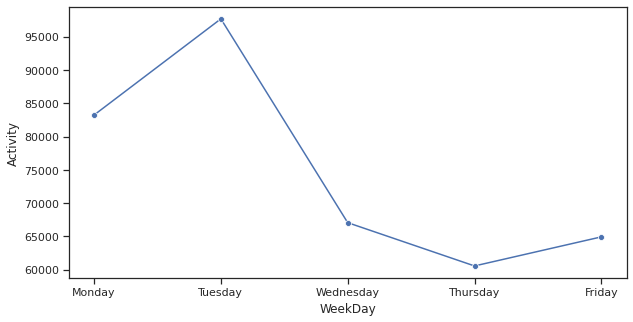

In [90]:
#Securities traded during weekdays
weekday_df = pd.DataFrame.from_dict(Counter(weekday_count), orient='index').reset_index()
weekday_df.columns =['WeekDay', 'Activity']
weekday_df['DayNumber'] = [0,4,2,1,3] 
weekday_df = weekday_df.sort_values(by='DayNumber')
print(weekday_df)
graph = sns.lineplot(weekday_df.WeekDay, weekday_df.Activity, marker='o')
plt.show()

    MonthDay  Activity
8          1      6656
0          2     41600
6          3     20778
2          4     30201
4          5     24080
1          6     12787
5          9      6640
3         10     13893
13        11     11359
14        12     29609
15        13      5093
19        16      2719
20        17      4503
9         18      5946
7         19      6867
12        20     44772
18        23     26129
10        24     51857
17        25     19556
11        27      2272
16        30      6146


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


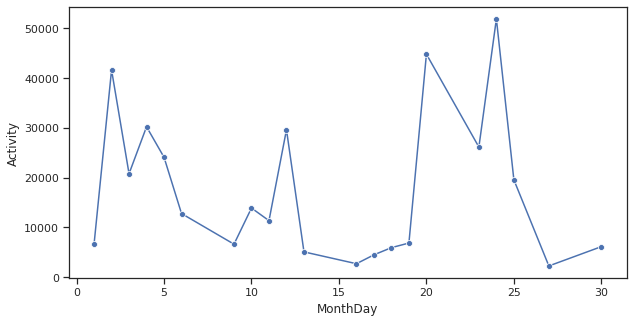

In [91]:
#How many securities are traded during the day.

days_df = pd.DataFrame.from_dict(Counter(days_count), orient='index').reset_index()
days_df.columns =['MonthDay', 'Activity']
days_df = days_df.sort_values(by='MonthDay')
print(days_df)
graph = sns.lineplot(days_df.MonthDay, days_df.Activity, marker='o')
plt.show()

In [92]:
#Most traded securities.
Securities_count = Counter(dataFrame['55'])
print(Securities_count)

Counter({'SSO': 161468, 'QLD': 51224, 'DBO': 29456, 'VXX': 29009, 'SOXX': 8965, 'FXI': 6813, 'YINN': 5969, 'TSLA': 4906, 'CHAD': 4828, -1: 4696, 'FSR': 3781, 'NKLA': 3163, 'SVXY': 3048, 'TBF': 2873, 'QS': 2730, 'AMZN': 2702, 'SBE': 2563, 'ACB': 2537, 'XPEV': 2363, 'AAPL': 2352, 'WKHS': 2247, 'RIDE': 1986, 'BLNK': 1842, 'CLVS': 1598, 'INO': 1367, 'UPRO': 1287, 'GME': 1211, 'TLRY': 1181, 'SPXW': 1175, 'BA': 1026, 'BABA': 999, 'PTON': 991, 'SDC': 826, 'GLD': 817, 'LMND': 790, 'MPLN': 779, 'MRNA': 767, 'UVXY': 743, 'TQQQ': 698, 'HYLN': 654, 'JWN': 622, 'ROKU': 611, 'ZM': 605, 'UCO': 604, 'SOXL': 560, 'NFLX': 518, 'NIO': 472, 'OSTK': 461, 'MSFT': 447, 'AMD': 446, 'PANW': 441, 'SPCE': 421, 'LI': 374, 'PYPL': 373, 'RIOT': 348, 'LULU': 299, 'ASHR': 274, 'FB': 261, 'USO': 258, 'DIS': 257, 'SHOP': 253, 'PLTR': 250, 'KNDI': 247, 'QCOM': 240, 'WORK': 240, 'UGL': 231, 'FSLY': 229, 'NNOX': 225, 'DBX': 222, 'HTZGQ': 209, 'SNOW': 202, 'WMT': 189, 'GRWG': 172, 'VIXY': 170, 'SJNK': 162, 'BIGC': 160, 'BI

In [97]:
#Time at which most of the activity happened.
print("Day of month with most activity is 24: ", days_count[24])
print("Hour of day with most activity is 16: ", hours_count[16])
print("Day of Week with most activity is 1: ", weekday_df['Activity'][3])

Day of month with most activity is 24:  51857
Hour of day with most activity is 16:  68378
Day of Week with most activity is 1:  97687


In [94]:
#How many executions from a specific destination.


In [95]:
#Latency/time taken by any destination after accepting the order and completely filling the order.